## Student #1 ID: 207047150

## Student #2 ID: 206727638

# Exercise 1: Decision Trees

In this assignment you will implement a Decision Tree algorithm as learned in class.

## Read the following instructions carefully:

1. This jupyter notebook contains all the step by step instructions needed for this exercise.
1. Write **efficient vectorized** code whenever possible. Some calculations in this exercise take several minutes when implemented efficiently, and might take much longer otherwise. Unnecessary loops will result in point deduction.
1. You are responsible for the correctness of your code and should add as many tests as you see fit. Those tests will not be graded nor checked.
1. You are free to add code and markdown cells as you see fit.
1. Write your functions in this jupyter notebook only. Do not create external python modules and import from them.
1. You are allowed to use functions and methods from the [Python Standard Library](https://docs.python.org/3/library/) and [numpy](https://www.numpy.org/devdocs/reference/) only, unless otherwise mentioned.
1. Your code must run without errors. It is a good idea to restart the notebook and run it from end to end before you submit your exercise.
1. Answers to qualitative questions should be written in **markdown cells (with $\LaTeX$ support)**.
1. Submit this jupyter notebook only using your ID as a filename. **No not use ZIP or RAR**. For example, your submission should look like this: `123456789.ipynb` if you worked by yourself or `123456789_987654321.ipynb` if you worked in pairs.

## In this exercise you will perform the following:
1. Practice OOP in python.
2. Implement two impurity measures: Gini and Entropy.
3. Construct a decision tree algorithm.
4. Prune the tree to achieve better results.
5. Visualize your results.

In [100]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# make matplotlib figures appear inline in the notebook
%matplotlib inline
plt.rcParams['figure.figsize'] = (10.0, 8.0) # set default size of plots
plt.rcParams['image.interpolation'] = 'nearest'
plt.rcParams['image.cmap'] = 'gray'

# Make the notebook automatically reload external python modules
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## Warmup - OOP in python

Our desicion tree will be implemented using a dedicated python class. Take a minute and practice your object oriented skills. Create a tree with some nodes and make sure you understand how objects in python work.

In [101]:
class Node(object):
    def __init__(self, data):
        self.data = data
        self.children = []

    def add_child(self, node):
        self.children.append(node)

In [102]:
n = Node(5)
p = Node(6)
q = Node(7)
n.add_child(p)
n.add_child(q)
n.children

[<__main__.Node at 0x2334d26ffa0>, <__main__.Node at 0x2334d26f100>]

## Data preprocessing

We will use the breast cancer dataset that is available as a part of sklearn. In this example, our dataset will be a single matrix with the **labels on the last column**. Notice that you are not allowed to use additional functions from sklearn.

In [103]:
from sklearn import datasets
from sklearn.model_selection import train_test_split

# load dataset
X, y = datasets.load_breast_cancer(return_X_y = True)
X = np.column_stack([X,y]) # the last column holds the labels

# split dataset
X_train, X_test = train_test_split(X, random_state=99)

print("Training dataset shape: ", X_train.shape)
print("Testing dataset shape: ", X_test.shape)



Training dataset shape:  (426, 31)
Testing dataset shape:  (143, 31)


In [104]:

lables = X_train[:,-1:]
l, lable_count = np.unique(lables, return_counts= True)
print(lable_count)
print(l)

[168 258]
[0. 1.]


## Impurity Measures (10 points)

Impurity is a measure of how often a randomly chosen element from the set would be incorrectly labeled if it was randomly labeled according to the distribution of labels in the subset. Implement the functions `calc_gini` (5 points) and `calc_entropy` (5 points). You are encouraged to test your implementation.

In [105]:
def calc_gini(data):
    """
    Calculate gini impurity measure of a dataset.
 
    Input:
    - data: any dataset where the last column holds the labels.
 
    Returns the gini impurity.    
    """
    gini = 1
    lables = data[:,-1:]
    num_of_all_labels = len(lables)
    _ , label_count = np.unique(lables, return_counts= True)
    gini -= sum((label_count/num_of_all_labels)**2)
    return gini

In [106]:
def calc_entropy(data):
    """
    Calculate the entropy of a dataset.

    Input:
    - data: any dataset where the last column holds the labels.

    Returns the entropy of the dataset.    
    """
    labels = data[:,-1:]
    num_of_all_labels = len(labels)
    _ , label_count = np.unique(labels, return_counts= True)
    pj = label_count/num_of_all_labels
    entropy = sum(-pj*np.log(pj))
    return entropy


In [107]:
print(f"Gini on train set: {calc_gini(X_train)}")
print(f"Entropy on train set: {calc_entropy(np.array(X_train))}")

Gini on train set: 0.47768299940488
Entropy on train set: 0.6706611269042888


In [108]:
class DecisionNode:

    def __init__(self, data):
        # you should take more arguments as inputs when initiating a new node
        self.data = data
        
        self.feature = None
        self.splitting_value = None
        unique_vals, counts = np.unique(self.data[:, -1], return_counts=True)
        self.prediction = unique_vals[np.argmax(counts)]

        self.leaf = True
        self.height = 1
        self.parent = None

        self.left_child = None
        self.right_child = None

    def add_child(self, node, side):
        if side == 'left':
            self.left_child = node
            self.left_child.height += self.height
            self.left_child.parent = self
        else:
            self.right_child = node
            self.left_child.height += self.height
            self.left_child.parent = self


        if (self.leaf):
            self.leaf = False


    def check_split(self, feature, value):
        # this function divides the data according to a specific feature and value
        # you should use this function while testing for the optimal split
        group_A = self.data[self.data[:,feature] <= value]
        group_B = self.data[self.data[:,feature] > value]
        return group_A, group_B

    def infogain(self, group_A, group_B, impurity_measure):
        s=self.data.shape[0]
        return impurity_measure(self.data) - ((group_A.shape[0]/s)*impurity_measure(group_A) + (group_B.shape[0]/s)*impurity_measure(group_B))

    def split(self, impurity_measure):
        # this function goes over all possible features and values and finds
        # the optimal split according to the impurity measure. Note: you can
        # send a function as an argument
        num_of_features = len(self.data[0]) - 1
        all_splits_infogains = dict()
        for feature in range(num_of_features):
            sorted_data_by_feature = np.sort(self.data[:,feature])
            thresholds = [(sorted_data_by_feature[i] + sorted_data_by_feature[i + 1]) / 2 for i in (range(len(sorted_data_by_feature) - 1))]
            for threshold in thresholds:
                group_A, group_B = self.check_split(feature, threshold)
                all_splits_infogains[self.infogain(group_A, group_B, impurity_measure)] = (feature, threshold)
        best_score = max(all_splits_infogains.keys())
        best_feature_and_value = all_splits_infogains[best_score]
        return best_feature_and_value

## Building a Decision Tree (50 points)

Use a Python class to construct the decision tree. Your class should support the following functionality:

1. Initiating a node for a decision tree. You will need to use several class methods and class attributes and you are free to use them as you see fit. We recommend that every node will hold the **feature** and **value** used for the split and the **children** of that node. In addition, it might be a good idea to store the **prediction** in that node, the **height** of the tree for that node and whether or not that node is a **leaf** in the tree.
2. Your code should support both Gini and Entropy as impurity measures. 
3. The provided data includes continuous data. For this exercise, create at most a **single split** for each node of the tree (your tree will be binary). Determine the threshold for splitting by checking all possible features and the values available for splitting. When considering the values, take the average of each consecutive pair. For example, for the values [1,2,3,4,5] you should test possible splits on the values [1.5, 2.5, 3.5, 4.5]. 
5. After you complete building the class for a decision node in the tree, complete the function `build_tree`. This function takes as input the training dataset and the impurity measure. Then, it initializes a root for the decision tree and constructs the tree according to the procedure you saw in class.
1. Once you are finished, construct two trees: one with Gini as an impurity measure and the other using Entropy.

In [109]:
def build_tree(data, impurity):
    """
    Build a tree using the given impurity measure and training dataset. 
    You are required to fully grow the tree until all leaves are pure. 
 
    Input:
    - data: the training dataset.
    - impurity: the chosen impurity measure. Notice that you can send a function
                as an argument in python.
 
    Output: the root node of the tree.
    """
    root = DecisionNode(data)
    if impurity(data) == 0:
        return root
    else:
        root.feature, root.splitting_value = root.split(impurity)
        group_A, group_B = root.check_split(root.feature, root.splitting_value)
        root.add_child(build_tree(group_A, impurity), 'left')
        root.add_child(build_tree(group_B, impurity), 'right')
        return root

In [110]:

tree_gini = build_tree(data=X_train, impurity=calc_gini) 
tree_entropy = build_tree(data=X_train, impurity=calc_entropy)

## Tree evaluation (10 points)

Complete the functions `predict` and `calc_accuracy`.

After building both trees using the training set (using Gini and Entropy as impurity measures), you should calculate the accuracy on the test set and print the measure that gave you the best test accuracy. For the rest of the exercise, use that impurity measure. (10 points)

In [111]:
def predict(node, instance):
    """
    Predict a given instance using the decision tree
 
    Input:
    - root: the root of the decision tree.
    - instance: an row vector from the dataset. 
 
    Output: the prediction of the instance.
    """
    if node.leaf:
        return node.prediction
    if (instance[node.feature] <= node.splitting_value):
        return predict(node.left_child, instance)
    else:
        return predict(node.right_child, instance)


In [112]:
def calc_accuracy(node, dataset):
    """
    Predict a given dataset using the decision tree
 
    Input:
    - node: a node in the decision tree.
    - dataset: the dataset on which the accuracy is evaluated
 
    Output: the accuracy of the decision tree on the given dataset (%).
    """
    rights = 0
    for instance in dataset:
        pred = predict(node,instance[:-1])
        if pred == int(instance[-1]):
            rights += 1
    accuracy = 100*(rights/len(dataset))
    return accuracy

In [113]:
print ( f" Gini tree's accuracy on test: {calc_accuracy(tree_gini, X_test)}")

print ( f" Entropy tree's accuracy on test: {calc_accuracy(tree_entropy, X_test)}")


 Gini tree's accuracy on test: 92.3076923076923
 Entropy tree's accuracy on test: 90.9090909090909


## Print the tree (10 points)

Complete the function `print_tree`. Your code should do something like this (10 points):
```
[X0 <= 1],
  [X1 <= 2]
    [X2 <= 3], 
       leaf: [{1.0: 10}]
       leaf: [{0.0: 10}]
    [X4 <= 5], 
       leaf: [{1.0: 5}]
       leaf: [{0.0: 10}]
   leaf: [{1.0: 50}]
```

In [114]:
def print_tree(node: DecisionNode, tabs= ""):
    """
    Prints the tree similar to the example above.
    As long as the print is clear, any printing scheme will be fine
    
    Input:
    - node: a node in the decision tree.
 
    Output: This function has no return value.
    """
    if node.leaf:
        print(f'{tabs}leaf: [{node.prediction}]' )
    else:
        print( f"{tabs}[{node.feature} <= {node.splitting_value}],")
    if (node.left_child):
        print_tree(node.left_child, tabs + "  ")
    if (node.right_child):
        print_tree(node.right_child, tabs + "  ")
    return
    


In [116]:
print("******************************************GINI TREE******************************************")
print_tree(tree_gini)
print("\n \n \n ******************************************ENTROPY TREE******************************************")
print_tree(tree_entropy)

******************************************GINI TREE******************************************
[27 <= 0.14235],
  [3 <= 696.25],
    [27 <= 0.1349],
      [13 <= 48.7],
        [21 <= 33.349999999999994],
          leaf: [1.0]
          [21 <= 33.56],
            leaf: [0.0]
            leaf: [1.0]
        [29 <= 0.07857],
          leaf: [0.0]
          leaf: [1.0]
      [27 <= 0.139],
        [25 <= 0.35845000000000005],
          leaf: [0.0]
          leaf: [1.0]
        leaf: [1.0]
    [21 <= 19.909999999999997],
      leaf: [1.0]
      [24 <= 0.08798],
        leaf: [1.0]
        [8 <= 0.15165],
          [29 <= 0.066435],
            leaf: [1.0]
            leaf: [0.0]
          leaf: [0.0]
  [13 <= 21.924999999999997],
    [27 <= 0.17885],
      [27 <= 0.14379999999999998],
        leaf: [0.0]
        leaf: [1.0]
      leaf: [0.0]
    [24 <= 0.096595],
      leaf: [1.0]
      leaf: [0.0]

 
 
 ******************************************ENTROPY TREE*********************************

## Post pruning (20 points)

Construct a decision tree and perform post pruning: For each leaf in the tree, calculate the test accuracy of the tree assuming no split occurred on the parent of that leaf and find the best such parent (in the sense that not splitting on that parent results in the best testing accuracy among possible parents). Make that parent into a leaf and repeat this process until you are left with the root. On a single plot, draw the training and testing accuracy as a function of the number of internal nodes in the tree. Explain and visualize the results and print your tree (20 points).

In [117]:

def simulate_pruning_accuracy(root : DecisionNode, node_to_cancel : DecisionNode, test_set):
    left_child= node_to_cancel.left_child
    right_child= node_to_cancel.right_child
    node_to_cancel.left_child = None
    node_to_cancel.right_child = None
    node_to_cancel.leaf= True
    accuracy_after_pruning_parent = calc_accuracy(root, test_set)
    node_to_cancel.left_child = left_child
    node_to_cancel.right_child = right_child
    node_to_cancel.leaf = False
    return accuracy_after_pruning_parent


def post_pruning(root: DecisionNode, test_set):
    """
    Perform post-pruning on the decision tree by pruning the best parent node.
    
    Parameters:
    - root: The root node of the decision tree.
    - test_set: The testing dataset (used for test accuracy calculation).
    
    Output:
    - The root of the pruned desision tree.
    """
    best_improvement = -101
    best_parent = None

    def find_best_parent_to_prune(node: DecisionNode):
        nonlocal best_improvement, best_parent

        if node.leaf:
            return
        
        if node.left_child.leaf and node.right_child.leaf:
            current_accuracy = calc_accuracy(root, test_set)
            pruned_accuracy = simulate_pruning_accuracy(root, node, test_set)
            
            
            accuracy_improvement = pruned_accuracy - current_accuracy
            if accuracy_improvement > best_improvement:
                best_improvement = accuracy_improvement
                best_parent = node
            
        
        if node and not node.left_child.leaf:
            find_best_parent_to_prune(node.left_child)
        if node and not node.right_child.leaf:
            find_best_parent_to_prune(node.right_child)

    find_best_parent_to_prune(root)
    
    if best_parent:
        best_parent.left_child = None
        best_parent.right_child = None
        best_parent.leaf = True
        best_parent.feature = None
        best_parent.splitting_value = None

In [118]:

tree_gini = build_tree(data=X_train, impurity=calc_gini)
accuracy_gini_before_pruning = calc_accuracy(tree_gini, X_test)
print(f'before pruning the accuracy of tree gini on train was {calc_accuracy(tree_gini, X_train)} and on test was {accuracy_gini_before_pruning}')

before pruning the accuracy of tree gini on train was 100.0 and on test was 92.3076923076923


In [119]:
import matplotlib.pyplot as plt

def pruning_visualisation(root : DecisionNode):
    test_accuracy_array = [calc_accuracy(root, X_test)]
    train_accuracy_array = [calc_accuracy(root, X_train)]
    num_of_pruned_nodes = 1
    while not root.leaf:
        num_of_pruned_nodes +=1
        post_pruning(root, X_test)
        test_accuracy_array.append(calc_accuracy(root, X_test))
        train_accuracy_array.append(calc_accuracy(root, X_train))

    x = range(num_of_pruned_nodes, 0 , -1)
    return train_accuracy_array , test_accuracy_array, x

train_acc, test_acc, x = pruning_visualisation(tree_gini)





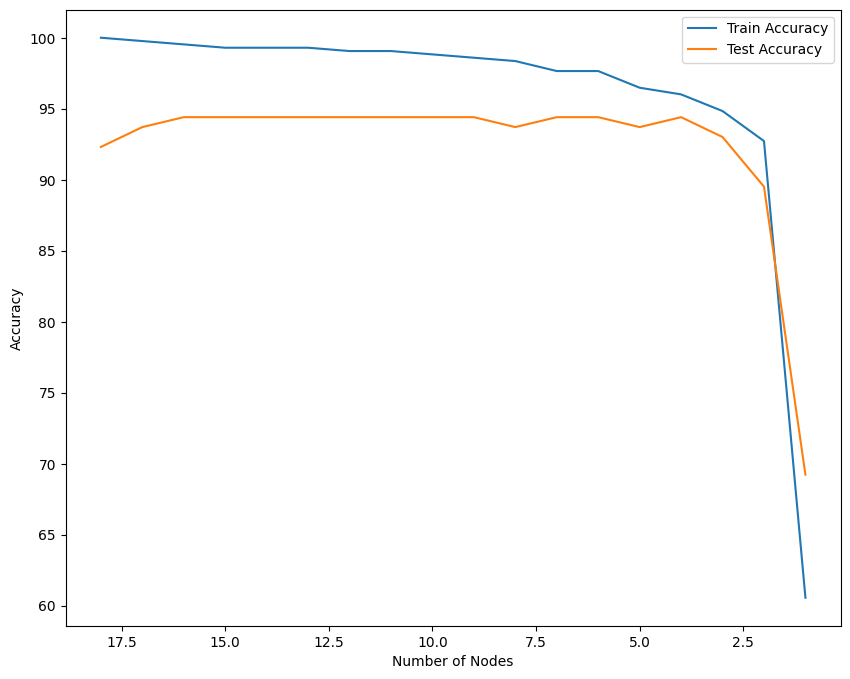

In [120]:
plt.plot(x, train_acc, label = "Train Accuracy")
plt.plot(x, test_acc, label = "Test Accuracy")
plt.xlabel("Number of Nodes")
plt.ylabel("Accuracy")
plt.legend()
plt.gca().invert_xaxis()
plt.show()

We can see the overfit phenomena as the test accuracy increases form 92 to  94 and then decreases as we get to the underfit phase. The train accuracy was initiated to 100 on the complete tree and then gradually decreases as we pruned the tree.

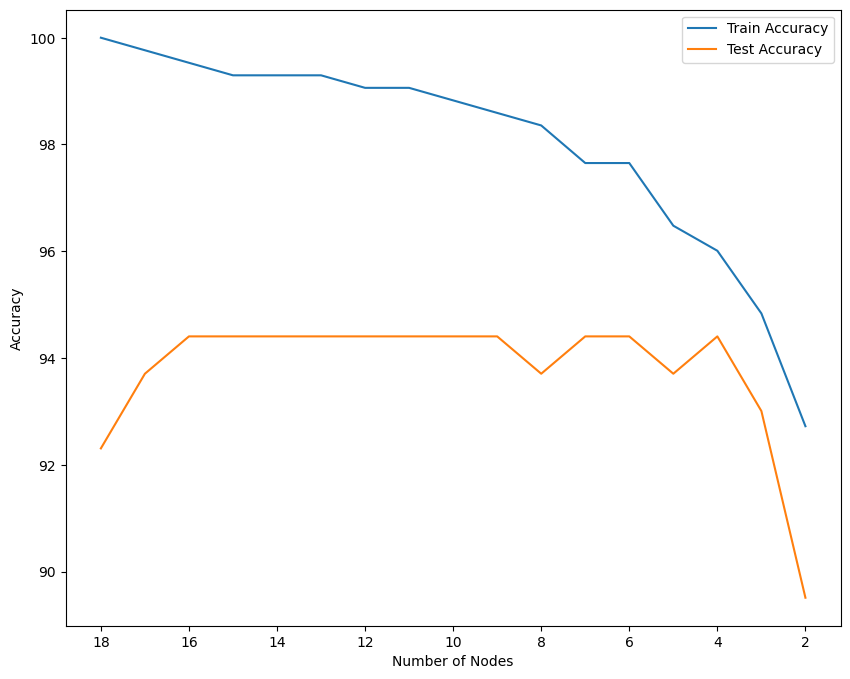

In [121]:
plt.plot(x[:-1], train_acc[:-1], label = "Train Accuracy")
plt.plot(x[:-1], test_acc[:-1], label = "Test Accuracy")
plt.xlabel("Number of Nodes")
plt.ylabel("Accuracy")
plt.legend()
plt.gca().invert_xaxis()
plt.show()

Another smaller scale graph to show the overfit phenomena

In [122]:
print_tree(tree_gini)

leaf: [1.0]
